# Drawing Figures
This Jupyter notebook can be used to replicate the figures (Fig.10 and Fig.11 corresponding to RQ1 and RQ5, respectively) involved in the empirical studies.  

## 1. Prelude

**Tips:**
+  Ensure that the current working directory is `./mstcs`. This is because `os.getcwd()` is used to obtain the absolute path of this notebook instead of `__file__`.
+  **Restart** the kernel for each run to avoid possible wrong localization of directory paths.
+  Note that all the raw data are stored in `./data/raw_data_for_empirical_results`.
+  Remember that all the generated figures (i.e., PDF files) are saved at `./data/plotting_for_empirical_results`.


To start with, we should configure `READ_DATA_DIR` and `SAVED_DATA_DIR`. `READ_DATA_DIR` refers to the name of the folder that store the intended raw data. We suggest it as either `rawdata` for visualizing data identical to our TOSEM paper or `data` for analyzing the replicated full data. We do not recommend `data(toy)` as it does not include complete experimental results. Meanwhile, we set `data` as the default `SAVED_DATA_DIR`.  

In [1]:
READ_DATA_DIR = "rawdata"
SAVED_DATA_DIR = "data"

Get the intended directories. Especially, we suggest that the following code block should be implemented only once if the Jupyter notebook is not planned to restart.

In [2]:
import os

# Getting script directory (compatible with interactive environments)
script_dir = os.getcwd()
# Building target path (fixing directory hierarchy)
parent_dir = os.path.dirname(script_dir)
raw_data_path = os.path.join(parent_dir, READ_DATA_DIR, "raw_data_for_empirical_results")   # For reading the raw data
saving_path = os.path.join(parent_dir, SAVED_DATA_DIR, "plotting_for_empirical_results")    # For saving the figures

## 2. Plotting for RQ1

The following code is used to visualize data involved in RQ1. The output figure corresponds to Fig.10 of this paper.

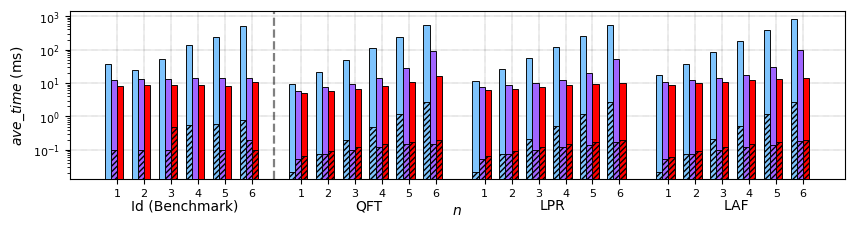

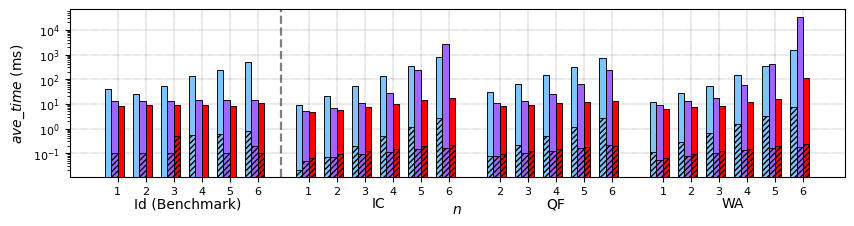

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Program abbreviations for labeling
abbriations_dict = {
    "Identity": "Id (Benchmark)", 
    "QFT": "QFT", 
    "LinearPauliRotations": "LPR",
    "LinearAmplitudeFunction": "LAF", 
    "IntegerComparator": "IC",
    "QuadraticForm": "QF", 
    "WeightedAdder": "WA"
}

# Define program groups for comparison
program_groups = {
    "group_1": ["Identity", "QFT", "LinearPauliRotations", "LinearAmplitudeFunction"],
    "group_2": ["Identity", "IntegerComparator", "QuadraticForm", "WeightedAdder"]
}

# Experiment versions and test case suffixes
versions = ['v1', 'v2', 'v3', 'v4', 'v5', 'v6']
test_cases = ['_PSTC', '_bits_MSTC', '_qubits_MSTC']

# Plotting style parameters
colors = ['#7FC4FD', '#A065FF', 'red']
width = 0.15
fontsize = 10
digitsize = 8
linewidth = 0.66 
hatch_linewidth = 0.3
hatch_form = '//////'
figsize = (10, 3)
group_spacing = 0.66        # Horizontal spacing factor between data points of a single program
group_gap = 0.54            # Extra gap between different programs
dotline_pos = 1.55          # Offset for vertical separator lines
dotline_width = 1.6

# Plot configuration (fine-tuning offsets)
config = {
    'title_vert_offset': -14,  # Vertical offset for program titles (negative = lower)
    'title_horz_offset': 7,    # Horizontal offset for program titles (points, +right / -left)
    'xtick_label_pad': 3,      # Vertical padding for x-axis tick labels (points)
}

# Ensure raw data directory exists and switch working directory
os.makedirs(raw_data_path, exist_ok=True)
os.chdir(raw_data_path)

# Iterate over program groups
for (group_name, programs) in program_groups.items():
    # Initialize figure
    fig, ax = plt.subplots(figsize=figsize)
    ax.set_yscale('log')  # Use log scale for Y-axis
    ax.grid(True, which='major', linestyle=':', color='black', linewidth=hatch_linewidth)

    # Variables for global positioning
    global_x = 0
    all_xticks = []
    all_xticklabels = []
    program_positions = []

    # Iterate over each program in the group
    for prog_idx, obj_program in enumerate(programs):
        file_dir = os.path.join(raw_data_path, 'RQ1', obj_program)
        program_data = []
        
        # Load and process test case data
        for case_idx, test_case in enumerate(test_cases):
            if obj_program == 'Identity':  # Special case: only one version
                df = pd.read_csv(os.path.join(file_dir, f'RQ1_{obj_program}{test_case}.csv'))
                x_column = df["n"].values
                avg_entire = df["ave_time(entire)"] * 1e3
                avg_prepare = df["ave_time(prepare)"] * 1e3
            else:  # Average across multiple versions
                columns, columns_below = [], []
                for version in versions:
                    df = pd.read_csv(os.path.join(file_dir, f'RQ1_{obj_program}_{version}{test_case}.csv'))
                    if not columns:
                        x_column = df["n"].values
                    columns.append(df["ave_time(entire)"])
                    columns_below.append(df["ave_time(prepare)"])
                avg_entire = pd.concat(columns, axis=1).mean(axis=1) * 1e3
                avg_prepare = pd.concat(columns_below, axis=1).mean(axis=1) * 1e3
            
            # Compute bar positions for this test case
            x_offset = global_x + np.arange(len(x_column)) * group_spacing + case_idx * width
            program_data.append((x_offset, avg_entire, avg_prepare))
        
        # Record center position of this program (for labeling)
        program_positions.append(global_x + (len(x_column)-1)*group_spacing/2)
        global_x += len(x_column) * group_spacing + group_gap  # Update offset for next program
        
        # Draw bars for each test case
        for case_idx, (x, entire, prepare) in enumerate(program_data):
            # Top bar: total execution time
            ax.bar(x, entire, width, 
                   color=colors[case_idx], edgecolor='black', 
                   linewidth=0.66, zorder=3)
            # Bottom bar (hatched): preparation time
            ax.bar(x, prepare, width, 
                   color=colors[case_idx], edgecolor='black', 
                   hatch='//////', linewidth=0.66, zorder=3)

        # Add vertical dashed line between program groups
        if prog_idx == 0:
            separator_x = global_x - (len(x_column)*group_spacing)/2 + dotline_pos
            ax.axvline(
                x=separator_x, 
                color='gray', 
                linestyle='--', 
                linewidth=dotline_width,
                alpha=1,
                zorder=0
            )

        # Collect x-axis tick positions and labels
        all_xticks.extend(program_data[0][0] + width*1.5)
        all_xticklabels.extend([f'{n}' for n in x_column])

    # Configure axis labels and ticks
    ax.set_xticks(all_xticks)
    ax.set_xticklabels(all_xticklabels, fontsize=fontsize)
    ax.set_xlabel('$n$', fontsize=fontsize)
    ax.set_ylabel(r'$ave\_time$ (ms)', fontsize=fontsize)
    plt.xticks(fontsize=digitsize)
    plt.yticks(fontsize=digitsize)

    # Adjust tick label vertical offset
    ax.tick_params(axis='x', pad=config['xtick_label_pad'])

    # Add program abbreviation labels under each group
    program_abb = [abbriations_dict[program] for program in programs]
    for pos, prog in zip(program_positions, program_abb):
        ax.annotate(
            prog,
            xy=(pos, 0),  # Anchor at x-position, bottom of axis
            xycoords=('data', 'axes fraction'),
            textcoords='offset points',  # Offset in points
            xytext=(config['title_horz_offset'], config['title_vert_offset']),
            ha='center',
            va='top',
            fontsize=fontsize,
            annotation_clip=False
        )

    # Adjust bottom margin to prevent label clipping
    plt.subplots_adjust(bottom=0.25 + abs(config['title_vert_offset'])/200)

    os.makedirs(saving_path, exist_ok=True)  # Create if it doesn't exist
    plt.savefig(os.path.join(saving_path, f'RQ1_{group_name}.pdf'),
                dpi=600, 
                bbox_inches='tight')

Draw the legend as a separate figure.

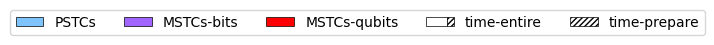

In [4]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.legend_handler import HandlerBase

# Create legend figure
fig_legend = plt.figure(figsize=(2.2 * 3, 0.3))
fontsize = 10
colors = ['#7FC4FD', '#A065FF', 'red', 'white', 'white']
labels2 = ['PSTCs', 'MSTCs-bits', 'MSTCs-qubits', 'time-entire', 'time-prepare']

# Custom handler for the 3/4 blank + 1/4 hatched patch
class HandlerPartialHatch(HandlerBase):
    def create_artists(self, legend, orig_handle,
                      xdescent, ydescent, width, height, fontsize, trans):
        # Create blank portion (3/4)
        blank = mpatches.Rectangle(
            xy=(xdescent, ydescent),
            width=width*0.75,
            height=height,
            facecolor='white',
            edgecolor='black',
            linewidth=0.5
        )
        # Create hatched portion (1/4)
        hatched = mpatches.Rectangle(
            xy=(xdescent + width*0.75, ydescent),
            width=width*0.25,
            height=height,
            facecolor='white',
            hatch='//////',
            edgecolor='black',
            linewidth=0.5
        )
        return [blank, hatched]

# Create standard legend handles
legend_handles = [
    mpatches.Patch(facecolor=colors[0], label=labels2[0]),  # PSTCs
    mpatches.Patch(facecolor=colors[1], label=labels2[1]),  # MSTCs-bits
    mpatches.Patch(facecolor=colors[2], label=labels2[2]),  # MSTCs-qubits
    object(),  # Placeholder for custom patch
    mpatches.Patch(facecolor='white', hatch='//////', label=labels2[4])  # time-prepare
]

# Set up legend axis
ax_legend = fig_legend.add_subplot(111)
ax_legend.axis('off')

# Create legend with custom handler
legend = ax_legend.legend(
    handles=legend_handles,
    labels=labels2,
    ncol=5,
    loc='center',
    fontsize=fontsize,
    handler_map={type(legend_handles[3]): HandlerPartialHatch()}
)

# Style adjustments for standard patches
for handle in legend.legend_handles[:3] + [legend.legend_handles[4]]:
    if hasattr(handle, 'set_edgecolor'):
        handle.set_edgecolor('black') # type: ignore
        handle.set_linewidth(0.5) # type: ignore

# Save the figure
fig_legend.savefig(
    os.path.join(saving_path, f'RQ1_legend.pdf'), 
    dpi=600, 
    bbox_inches='tight', 
    pad_inches=0.1
)

## 3. Plotting for RQ5

The following code is used to visualize data involved in RQ5. The output figure corresponds to Fig.11 of this paper.

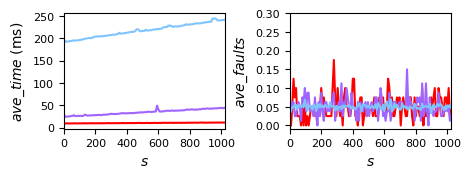

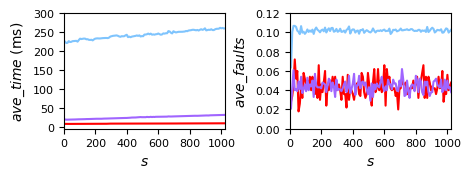

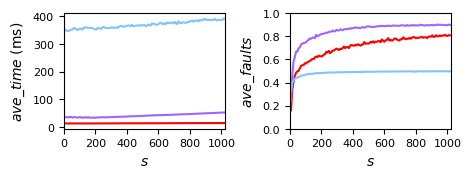

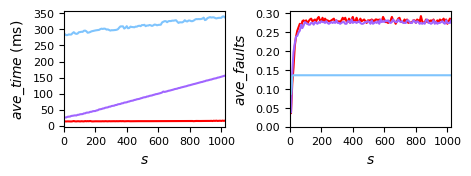

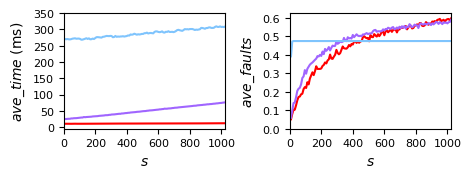

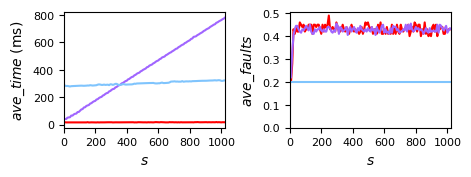

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

# Program configuration dictionary containing timing and fault parameters
programs_config = {
    "QFT": {
        "time_range": range(0, 251, 50),          # Time range in milliseconds
        "faults_range": np.arange(0, 0.31, 0.05)  # Fault probability range
    },
    "LinearPauliRotations": {
        "time_range": range(0, 301, 50),
        "faults_range": np.arange(0, 0.121, 0.02)
    },
    "LinearAmplitudeFunction": {
        "time_range": range(0, 401, 100),
        "faults_range": np.arange(0, 1.01, 0.2)
    },
    "IntegerComparator": {
        "time_range": range(0, 351, 50),
        "faults_range": np.arange(0, 0.31, 0.05)
    },
    "QuadraticForm": {
        "time_range": range(0, 351, 50),
        "faults_range": np.arange(0, 0.61, 0.1)
    },
    "WeightedAdder": {
        "time_range": range(0, 801, 200),
        "faults_range": np.arange(0, 0.51, 0.1)
    }
}

# Test case configurations with filename suffixes and colors
test_cases_setting = [
    ('_MSTC(1MS).csv', 'red'),       # Single mitigation strategy
    ('_MSTC(2MS).csv', '#A065FF'),   # Dual mitigation strategy
    ('_PSTC.csv', '#7FC4FD')         # Probabilistic strategy
]

# Global plotting parameters
plot_params = {
    'fontsize': 10,                  # Base font size for labels
    'digitsize': 8,                  # Tick label font size
    'xlim': (0, 1024),               # X-axis limits
    'xticks': np.arange(0, 1001, 200),  # X-axis tick positions
    'figsize': (3.1 * 2, 1.5),       # Figure dimensions (width, height)
    'wspace': 0.4,                   # Horizontal space between subplots
    'right': 0.75                    # Right margin position
}

def configure_axes(ax, config, is_time_axis):
    """Configure axis parameters with given settings."""
    ax.set_xlabel('$s$', fontsize=plot_params['fontsize'])
    ax.set_xlim(plot_params['xlim'])
    ax.set_xticks(plot_params['xticks'])
    ax.tick_params(axis='both', labelsize=plot_params['digitsize'])
    
    if is_time_axis:
        ax.set_ylabel(r'$ave\_time$ (ms)', fontsize=plot_params['fontsize'])
        ax.set_yticks(config["time_range"])
    else:
        ax.set_ylabel(r'$ave\_faults$', fontsize=plot_params['fontsize'])
        ax.set_yticks(config["faults_range"])

# Main execution flow
for obj_program in programs_config:
    fig, ax = plt.subplots(1, 2, figsize=plot_params['figsize'])
    ax_time, ax_fault = ax[0], ax[1]
    current_config = programs_config[obj_program]
    file_dir = os.path.join(raw_data_path, 'RQ5', obj_program)
    # Process each test case
    for suffix, color in test_cases_setting:
        data = pd.read_csv(os.path.join(file_dir, f'RQ5_{obj_program}_v1{suffix}'))
        x_values = data["shots"]
        
        # Plot time axis
        ax_time.plot(x_values, data["ave_time"] * 1e3, color=color)
        # Plot fault axis
        ax_fault.plot(x_values, data["faults"], color=color)
    
    # Configure axis parameters
    configure_axes(ax_time, current_config, is_time_axis=True)
    configure_axes(ax_fault, current_config, is_time_axis=False)
    
    # Adjust layout and save figure
    plt.subplots_adjust(wspace=plot_params['wspace'], right=plot_params['right'])
    plt.savefig(
        os.path.join(saving_path, f'RQ5_{obj_program}.pdf'), 
        dpi=600, 
        bbox_inches='tight', 
        pad_inches=0.1
    )

Then, draw the legend as a separate figure.

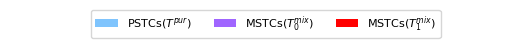

In [6]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Create legend figure with specified dimensions
fig_legend = plt.figure(figsize=(6.6, 0.3))   
colors = ['#7FC4FD', '#A065FF', 'red']
labels = ['PSTCs($T^{pur}$)', 'MSTCs($T^{{mix}}_0$)', 'MSTCs($T^{{mix}}_1$)']

# Generate legend handles using list comprehension
legend_handles = [mpatches.Patch(facecolor=c, label=l) for c, l in zip(colors, labels)]

# Configure axis and legend
ax = fig_legend.add_subplot(111)
ax.axis('off')
ax.legend(ncol=3, handles=legend_handles, loc='center', fontsize=8)

# Export legend figure
fig_legend.savefig(
    os.path.join(saving_path, f'RQ5_legend.pdf'), 
    dpi=600, 
    bbox_inches='tight', 
    pad_inches=0.1
)